### **Laboratorio 5**
- Juan Pablo Solis
- Diego Garcia

### **Investigacion RNN**

La capa RNN en PyTorch es una de las más básicas para trabajar con secuencias. Lo primero que hay que saber es cuál es el input que espera. Normalmente, el tensor de entrada tiene tres dimensiones: (seq_len, batch_size, input_size) cuando usamos la configuración por defecto. Aquí, seq_len es la longitud de la secuencia (cuántos pasos en el tiempo hay), batch_size es el número de ejemplos que se procesan a la vez y input_size es el número de características de cada paso temporal. Si activamos la opción batch_first=True, entonces el formato cambia y sería (batch_size, seq_len, input_size), lo que a veces es más fácil de usar.

En cuanto al output, la capa devuelve dos cosas. La primera es output, que contiene la salida de todos los pasos de la secuencia, es decir, cómo va evolucionando la información en cada instante. La segunda es h_n, que guarda el estado oculto final de la red, una especie de “resumen” de toda la secuencia procesada. Este estado final es muy útil cuando queremos pasar información a otra capa o predecir usando solo la última representación.

Respecto a los parámetros de configuración, los más importantes son: input_size, que indica el número de características de entrada; hidden_size, que define el tamaño del estado oculto; y num_layers, que permite apilar varias RNN para hacer la red más profunda. También se puede elegir la función de activación (tanh o relu), activar la opción bidirectional para que la red lea la secuencia en los dos sentidos, y usar batch_first para reorganizar la forma del input.

Sobre el dataset Sunspots, este registra el número de manchas solares observadas en el Sol cada mes. Estas manchas están relacionadas con la actividad magnética del Sol y tienen ciclos aproximados de once años. El dataset cubre un rango temporal muy grande, pues hay datos desde el año 1700 hasta la actualidad en algunas versiones. Esto lo hace muy interesante porque no muchos conjuntos de datos tienen registros tan largos.

Es un dataset muy útil para predecir series temporales porque muestra un comportamiento cíclico y repetitivo. Esto significa que se pueden entrenar modelos como RNN, LSTM o incluso modelos estadísticos como ARIMA para aprender la estacionalidad y los patrones de largo plazo. Justamente por eso, los Sunspots suelen usarse como ejemplo clásico para probar y comparar algoritmos de predicción.

Primeras filas del dataset:
     YEAR  SUNACTIVITY
0  1700.0          5.0
1  1701.0         11.0
2  1702.0         16.0
3  1703.0         23.0
4  1704.0         36.0


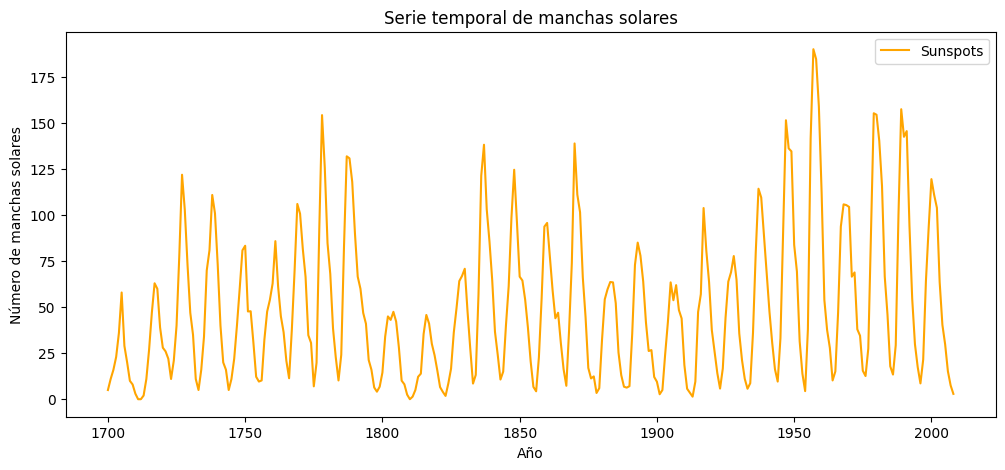


Datos normalizados:
     YEAR  SUNACTIVITY  SUNACTIVITY_norm
0  1700.0          5.0          0.026288
1  1701.0         11.0          0.057834
2  1702.0         16.0          0.084122
3  1703.0         23.0          0.120925
4  1704.0         36.0          0.189274

 Dataset normalizado guardado como 'sunspots_normalized.csv'


In [2]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from statsmodels.datasets import sunspots

# Cargar el dataset
data = sunspots.load_pandas().data

# Mostrar primeras filas
print("Primeras filas del dataset:")
print(data.head())

# Visualización inicial de la serie completa
plt.figure(figsize=(12,5))
plt.plot(data['YEAR'], data['SUNACTIVITY'], color="orange", label="Sunspots")
plt.xlabel("Año")
plt.ylabel("Número de manchas solares")
plt.title("Serie temporal de manchas solares")
plt.legend()
plt.show()

# Normalización de los datos
scaler = MinMaxScaler(feature_range=(0,1))
data['SUNACTIVITY_norm'] = scaler.fit_transform(data[['SUNACTIVITY']])

# Mostrar los datos normalizados
print("\nDatos normalizados:")
print(data.head())

data.to_csv("sunspots_normalized.csv", index=False)
print("\n Dataset normalizado guardado como 'sunspots_normalized.csv'")


### **Implementacion de RNN Basica**



In [19]:
import torch
import torch.nn as nn
import numpy as np

# Crear dataset de secuencias con ventana de 10 pasos
def create_sequences(data, seq_length=10):
    xs, ys = [], []
    for i in range(len(data)-seq_length):
        x = data[i:i+seq_length]
        y = data[i+seq_length]
        xs.append(x)
        ys.append(y)
    return np.array(xs), np.array(ys)

# Definir el modelo RNN
class RNNModel(nn.Module):
    def __init__(self, input_size=1, hidden_size=32, num_layers=1, output_size=1):
        super(RNNModel, self).__init__()
        self.rnn = nn.RNN(input_size, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        out, h = self.rnn(x)           # out: (batch, seq_len, hidden_size)
        out = out[:, -1, :]            # se toma solo el último paso
        out = self.fc(out)             # se pasa por la capa fully connected
        return out
    
def entrenar_y_predecir(seq_length=10, hidden_size=32, epochs=30, lr=0.001, series=data['SUNACTIVITY_norm'].values):
    print(f"\n===== Ventana = {seq_length} =====")
    
    # Crear secuencias
    X, y = create_sequences(series, seq_length)

    # Convertir a tensores de PyTorch
    X_tensor = torch.tensor(X, dtype=torch.float32).unsqueeze(-1)  
    y_tensor = torch.tensor(y, dtype=torch.float32).unsqueeze(-1)


    # Instanciar el modelo
    model = RNNModel()

    # Definir función de pérdida y optimizador
    criterion = nn.MSELoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

    # Entrenamiento
    for epoch in range(epochs):
        model.train()
        optimizer.zero_grad()

        output = model(X_tensor)
        loss = criterion(output, y_tensor)

        loss.backward()
        optimizer.step()

        if (epoch+1) % 5 == 0:
            print(f"Epoch {epoch+1}/{epochs}, Loss: {loss.item():.6f}")

    # Probar predicciones
    model.eval()
    with torch.no_grad():
        predictions = model(X_tensor).numpy()

    # Graficar resultados
    plt.figure(figsize=(12,5))
    plt.plot(series, label="Serie original")
    plt.plot(range(seq_length, seq_length+len(predictions)), predictions, label="Predicciones RNN")
    plt.xlabel("Tiempo")
    plt.ylabel("Sunspots normalizados")
    plt.legend()
    plt.show()

    return model, loss.item()




===== Ventana = 10 =====
Epoch 5/30, Loss: 0.033902
Epoch 10/30, Loss: 0.024563
Epoch 15/30, Loss: 0.014691
Epoch 20/30, Loss: 0.012064
Epoch 25/30, Loss: 0.010171
Epoch 30/30, Loss: 0.009277


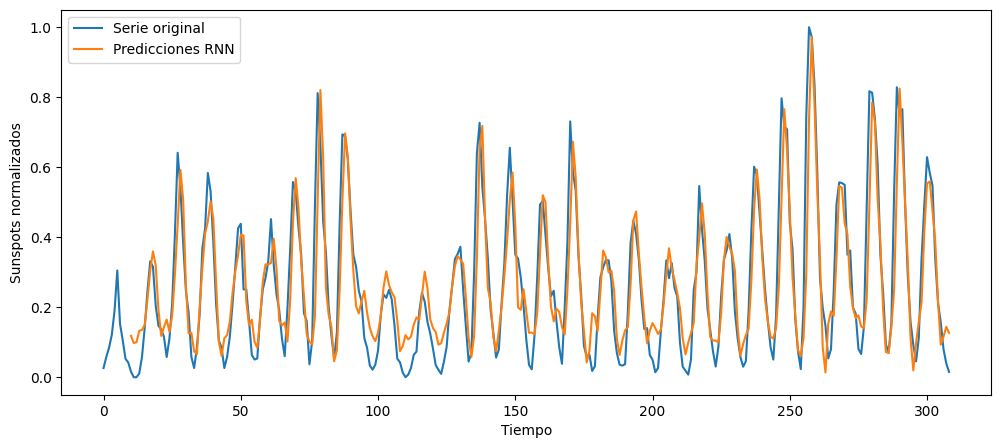

(RNNModel(
   (rnn): RNN(1, 32, batch_first=True)
   (fc): Linear(in_features=32, out_features=1, bias=True)
 ),
 0.009276599623262882)

In [20]:
seq_length = 10
entrenar_y_predecir(seq_length=seq_length, epochs=30)



===== Ventana = 5 =====
Epoch 5/50, Loss: 0.046290
Epoch 10/50, Loss: 0.035485
Epoch 15/50, Loss: 0.024726
Epoch 20/50, Loss: 0.015569
Epoch 25/50, Loss: 0.014013
Epoch 30/50, Loss: 0.011342
Epoch 35/50, Loss: 0.009636
Epoch 40/50, Loss: 0.009221
Epoch 45/50, Loss: 0.008707
Epoch 50/50, Loss: 0.008101


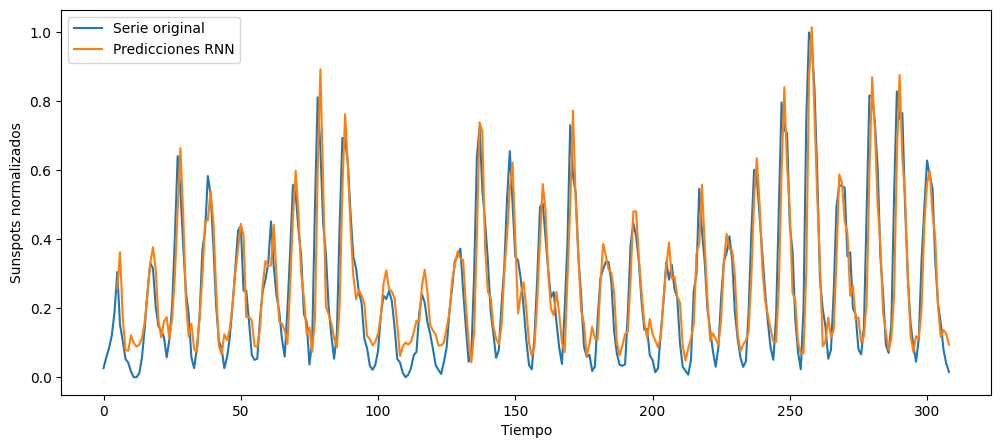


===== Ventana = 20 =====
Epoch 5/50, Loss: 0.036515
Epoch 10/50, Loss: 0.020847
Epoch 15/50, Loss: 0.013060
Epoch 20/50, Loss: 0.012210
Epoch 25/50, Loss: 0.009854
Epoch 30/50, Loss: 0.008894
Epoch 35/50, Loss: 0.008009
Epoch 40/50, Loss: 0.007595
Epoch 45/50, Loss: 0.007113
Epoch 50/50, Loss: 0.006750


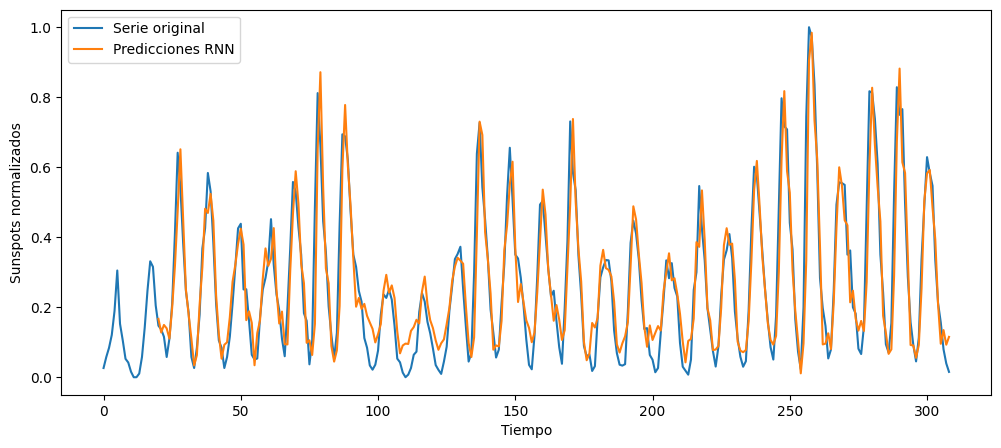


===== Ventana = 100 =====
Epoch 5/50, Loss: 0.048088
Epoch 10/50, Loss: 0.041206
Epoch 15/50, Loss: 0.033084
Epoch 20/50, Loss: 0.025080
Epoch 25/50, Loss: 0.015984
Epoch 30/50, Loss: 0.014817
Epoch 35/50, Loss: 0.011497
Epoch 40/50, Loss: 0.011339
Epoch 45/50, Loss: 0.010153
Epoch 50/50, Loss: 0.009375


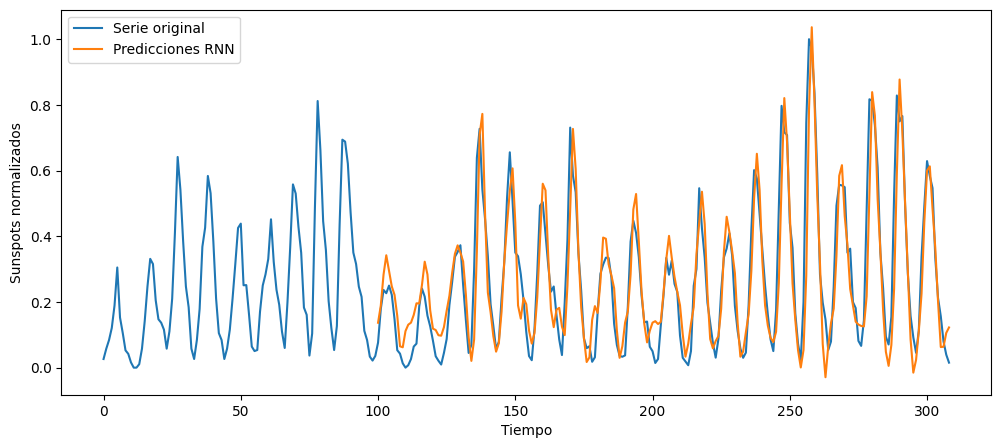

In [ ]:
# Experimentar con diferentes tamaños de ventana
for ventana in [5, 20, 100]:
    entrenar_y_predecir(seq_length=ventana, epochs=50)

**Cambio en el desempeño de la red**

Con ventana pequeña (5), el modelo aprende patrones muy locales. Logra capturar algo de la forma de la serie, pero tiene problemas al seguir los ciclos más amplios de las manchas solares. Aunque el error baja bastante, aproximadamente 0.0081, la capacidad de generalización es muy limitada y las predicciones tienden a suavizarse.
Con ventana mediana (20), el modelo alcanza un mayor equilibrio. Esto se ve inicialmente en que el error es más bajo, aproximadamente 0.0067, y en la gráfica se aprecia como se sigue muy bien tanto los picos como los valles de la serie. El modelo dispone de suficiente contexto para capturar periodicidad, pero no queda sesgado por los mismos datos.
Con ventana grande (100), el desempeño sigue siendo aceptable, pero el error es mayor, aproximadamente 0.0094. El modelo tiene que manejar dependencias largas y, al ser una RNN simple, le cuesta mantener toda la información en los estados ocultos. Por eso es que en algunas partes de la gráfica se ve como el modelo hace predicciones por inercia y va perdiendo precisión en algunas áreas.


**Problemas de entrenamiento**

En este caso, no se logra observar ningún signo de explosión de gradiente, ya que el error no llega a tener cambios o oscilaciones bruscas ni diverge. En la ventana grande, se logran apreciar señales de un desvanecimiento de gradiente. El error va bajando más lento conforme pasan las epochs y llega a estancarse en un punto. Esto refleja la dificultad que tienen las RNN clásicas para aprender dependencias largas. Con ventanas pequeñas y medianas, la convergencia es estable y no se observan problemas graves.


**Tiempo de entrenamiento y estabilidad de error**
Con una ventana pequeña, el entrenamiento es rápido y estable, se llega pronto a una convergencia, pero tiene una menor capacidad de modular la estuctura global. Por otro lado, con una ventana mediana el tiempo de entrenamiento es un poco más tardado, pero tampoco es mucha diferencia. Además, el error desciende de forma consistente hasta estabilizarse en el nivel más bajo. Esto lo convierte en el más eficiente. Con una ventana grande, el entrenamiento es más lento, ya que cada batch debe procesar más pasos. Además, el error es más alto que los otros dos y mientras más pasa el tiempo, más parece estancarse en un punto.